This tutorial demonstrates text classification, starting with simple text files stored on disk. You will train a binary classifier to perform sentiment analysis on the IMDB dataset. At the end of the notebook, you can try an exercise in which you train a multiclass classifier to predict a tag for a programming question in Stack Overflow.

In [91]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

# **Attitude Analysis**
This notebook trains a model of sentiment analysis to classify movie reviews as positive or negative based on the review text. This is an example of binary - or two-class - classification, an important and widely applicable machine learning problem.

You will use a large movie review dataset , which contains the text of 50,000 movie reviews from an online movie database . These are divided into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain equal amounts of positive and negative reviews.

***Download and explore the IMDB dataset***

In [92]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [93]:
os.listdir(dataset_dir)

['train', 'README', 'test', 'imdb.vocab', 'imdbEr.txt']

In [94]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'neg',
 'pos',
 'urls_unsup.txt',
 'unsup',
 'urls_neg.txt',
 'unsupBow.feat',
 'labeledBow.feat']

aclImdb/train/pos and aclImdb/train/neg contain many text files, each representing a different movie review. Let's take a look at one of them.



In [95]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# **Load the dataset**

Next, you will load the data from disk and prepare it in a format suitable for training. To do this, you will use the useful utility text_dataset_from_directory , which expects the following directory structure.


To prepare the dataset for binary classification, you will need two folders on disk corresponding to class_a and class_b . These will be the positive and negative movie reviews found in aclImdb/train/pos and aclImdb/train/neg . Since the IMDB dataset contains additional folders, you will delete them before using this utility.

In [96]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset . tf.data is a powerful set of tools for working with data.



When conducting a machine learning experiment, it is recommended to divide the dataset into three parts: ***training , validation and testing*** .

IMDB dataset is already divided into training and testing dataset, but it lacks a validation dataset. Let's create a validation set using 80:20 split of training data using the validation_split argument below .

In [97]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training.

As you will soon see, you can train a model by passing the dataset directly to model.fit . If you are new to tf.data , you can also loop over the dataset and print some examples as follows.

In [98]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Note that reviews contain raw text (with punctuation and random HTML tags such as <br/> ). You will show how to handle them in the next section.

Labels are either 0 or 1. To see which ones correspond to positive and negative movie reviews, you can check the class_names property in the dataset.


In [99]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a data set for **validation and testing**. You will use the remaining 5,000 reviews from the training set for validation.

In [100]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [101]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# **Prepare the dataset for training**
Next you will ***standardize, tokenize and vectorize*** the data using the useful layer tf.keras.layers.TextVectorization .

**Standardization** refers to text preprocessing, usually to remove punctuation marks or HTML elements to simplify the data set.

**Tokenization** refers to breaking strings into tokens (e.g., breaking a sentence into individual words by breaking them by whitespace).

**Vectorization** refers to converting tokens into numbers so that they can be passed to a neural network. All of these tasks can be accomplished using this layer.

As you have seen above, overviews contain various HTML tags such as <br />.
These tags will not be removed by the default standardizer in the ***TextVectorization layer*** (which by default converts text to lower case and removes punctuation, but does not remove HTML). You will write a custom standardizer function to remove HTML.

In [102]:

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')



 Next, you will create a ***TextVectorization layer*** . You will use this layer to standardize, tokenize, and vectorize our data. You will set the output_mode parameter to int , to create unique integer indexes for each token.

Notice that you use the default partitioning function and the custom standardization function you defined above. You will also define some constants for the model, such as an explicit maximum sequence_length , which will force the layer to append or truncate sequences exactly to sequence_length values .


Translated with DeepL.com (free version)

In [103]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

You will then call adapt , to fit the state of the preprocessing layer to the dataset. This will force the model to build a row index for integers.

In [104]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [105]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [106]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T


As you can see above, each token has been replaced by an integer. You can find the token (string) that each integer corresponds to by **calling .get_vocabulary()** on the layer.


In [107]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [108]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

#**Customize the dataset for performance**

These are two important methods you should use when loading data to make sure I/O is not blocked.

**.cache()** stores the data in memory after it is loaded from disk. This ensures that the dataset does not become a bottleneck when training your model. If your dataset is too large to fit in memory, you can also use this method to create a performance cache on disk that is more efficient to read than many small files.

**.prefetch()** overrides data preprocessing and model execution during training.

You can learn more about both methods, as well as how to cache data to disk, in the Data Performance Guide .

In [109]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Create a model**

In [110]:
embedding_dim = 16

In [111]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**The layers are stacked sequentially to build the classifier:**

1. The first layer is the **Embedding layer** .
 This layer takes reviews in integer encoding and looks for an embedding vector for each word index. These vectors are learned as the model is trained. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding) . To learn more about embeddings, see the word embedding tutorial .

2. **The GlobalAveragePooling1D layer** then returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle variable length input in the simplest way possible.

3. This fixed length output vector is passed through a fully connected ( Dense ) layer with 16 hidden units.

4. The latter layer is tightly coupled to a single output node.


#**Loss function and optimizer**

The model needs a **loss function and an optimizer for training**. Since this is a binary classification problem and the model outputs a probability (single element layer with sigmoid activation), you will use the loss function **losses.BinaryCrossentropy** .

Now set up the model to use the optimizer and the loss function:


In [112]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.0)])


#**Train the model**

You train the model by passing a dataset object to the fit method.


In [113]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - binary_accuracy: 0.5816 - loss: 0.6809 - val_binary_accuracy: 0.7340 - val_loss: 0.6121
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - binary_accuracy: 0.7609 - loss: 0.5791 - val_binary_accuracy: 0.8088 - val_loss: 0.4987
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8208 - loss: 0.4662 - val_binary_accuracy: 0.8332 - val_loss: 0.4268
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.8524 - loss: 0.3949 - val_binary_accuracy: 0.8344 - val_loss: 0.3903
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - binary_accuracy: 0.8661 - loss: 0.3474 - val_binary_accuracy: 0.8490 - val_loss: 0.3606
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.8807 - loss: 0.3156 - val_binary_accuracy: 0.8540 - val_loss: 0.3432
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - binary_accuracy: 0.8904 - loss: 0.2896 - val_binary_accuracy: 0.8544 - val_loss: 0.3335
Epoch

#**Evaluate the model**
Let's see how the model behaves. Two values will be returned. Loss (a number that represents our error, the smaller the value the better) and accuracy.


In [114]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8572 - loss: 0.3304
Loss:  0.3311449885368347
Accuracy:  0.8571199774742126


#**Create a graph of accuracy and loss over time**
**model.fit()** returns a History object , containing a dictionary of everything that happened during training:


In [115]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

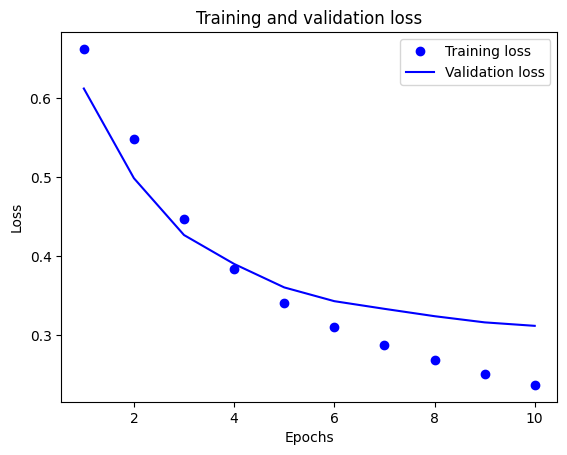

In [116]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

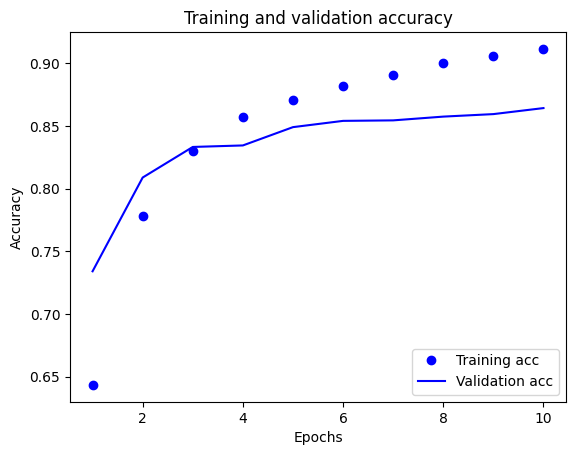

In [117]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this graph, the dots represent learning loss and accuracy, and the solid lines represent verification loss and accuracy.

Note that the training loss decreases with each epoch, while the training accuracy increases with each epoch. This is expected when using gradient descent optimization - it should minimize the desired quantity at each iteration.

This is not the case for validation and accuracy losses - they seem to peak before learning accuracy. This is an example of over-learning: the model performs better on training data than on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that don't generalize to the test data.

In this particular case, you can prevent overfitting by simply stopping training when the test accuracy stops increasing. One way to do this is to use the **tf.keras.callbacks.EarlyStopping** .



# ***Exporting the model***

In the above code, you applied a **TextVectorization** layer to the dataset before passing the text to the model. If you want your model to be able to handle raw strings (for example, to make it easier to deploy), you can include a TextVectorization layer in the model . To do this, you can create a new model using the weights you just trained.


In [119]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
# Capture all returned values
all_metrics = export_model.evaluate(raw_test_ds)

# Extract loss and accuracy (assuming they are the first two values)
loss, accuracy = all_metrics[:2]

print(accuracy)


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8567 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
0.0


# **Output from new data**
To get predictions for new samples, you can simply call model.predict() .
